# Load and test trained model

## Load libraries

In [1]:
import numpy as np
import torch

import torch.nn as nn
from enduro_lstm import *

In [2]:
device = conf_cuda(False)

Selected CPU


In [3]:
device

device(type='cpu')

In [4]:
device.type

'cpu'

## Set configurations

In [35]:
data_path = r"../1-generate/data/"
match = 50
use_cuda = False
zigzag = False
is_softmax = True

## Load trained model

In [6]:
path = 'models/continue_m45to50_f1to1000_epoch20001to30000_H200/'
newpath = path + 'continue_m45to50_f1to1000_epoch20001to30000_H200'

In [7]:
hidden_neurons = 200
load_checkpoint = True

In [8]:
if zigzag:
    output_size = 2
else:
    output_size = 9

In [9]:
def load_checkpoint(model, filename='checkpoint.pth.tar'):
    
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])

    return model

In [36]:
if load_checkpoint:
    model = Model(device=device, input_size=20400, output_size=output_size, hidden_dim=hidden_neurons, n_layers=1, is_softmax=is_softmax)
    model = load_checkpoint(model, newpath)
else:
    model = Model(device=device, input_size=20400, output_size=output_size, hidden_dim=hidden_neurons, n_layers=1, is_softmax=is_softmax)
    model.load_state_dict(torch.load(newpath, map_location=device))
model.eval()

=> loading checkpoint 'models/continue_m45to50_f1to1000_epoch20001to30000_H200/continue_m45to50_f1to1000_epoch20001to30000_H200'


Model(
  (lstm): LSTM(20400, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=9, bias=True)
  (out): Softmax(dim=None)
)

In [59]:
model = Model(device=device, input_size=20400, output_size=output_size, hidden_dim=hidden_neurons, n_layers=1, is_softmax=is_softmax)
torch.load(newpath, map_location=device)
model.eval()

Model(
  (lstm): LSTM(20400, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=9, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)

num_of_frames_arr = []
frames_arr = []
actions_arr = []

start_frame = 1
end_frame = 1000

for m in range(45, 50 + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

X_train = np.array(frames_arr)/255
Y_train = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.


In [21]:
X_train.shape

torch.Size([6, 1000, 20400])

In [36]:
out, h = model(X_train)

In [38]:
out.shape

torch.Size([6000, 9])

In [39]:
criterion = nn.MSELoss()

In [40]:
loss = criterion(out, Y_train.view(-1,len(ACTIONS_LIST)).float())

In [41]:
loss

tensor(0.0264, grad_fn=<MseLossBackward>)

In [43]:
out, h = model(X_train[0].reshape(1, 1000, 20400))

In [45]:
loss = criterion(out, Y_train[0].view(-1,len(ACTIONS_LIST)).float())

In [46]:
loss

tensor(0.0250, grad_fn=<MseLossBackward>)

In [47]:
out, h = model(X_train[1].reshape(1, 1000, 20400))

In [48]:
loss = criterion(out, Y_train[1].view(-1,len(ACTIONS_LIST)).float())

In [50]:
loss.item()

0.029183954000473022

## Prepare cell with trained model 

In [11]:
lstmcell = nn.LSTMCell(20400, hidden_neurons)
linear = nn.Linear(hidden_neurons, output_size)
if is_softmax:
    output = nn.Softmax()
else:
    output = nn.Sigmoid()

In [12]:
lstmcell.weight_ih = model.lstm.weight_ih_l0
lstmcell.weight_hh = model.lstm.weight_hh_l0
lstmcell.bias_hh = model.lstm.bias_hh_l0
lstmcell.bias_ih = model.lstm.bias_ih_l0
linear.weight = model.fc.weight
linear.bias = model.fc.bias

In [13]:
hx = torch.zeros(1, hidden_neurons)
cx = torch.zeros(1, hidden_neurons)

In [14]:
print(model.lstm.weight_ih_l0.shape)
print(model.lstm.weight_hh_l0.shape)
print(model.lstm.bias_ih_l0.shape)
print(model.lstm.bias_hh_l0.shape)
print(model.fc.weight.shape)
print(model.fc.bias.shape)

torch.Size([800, 20400])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([9, 200])
torch.Size([9])


## Plot graphs

In [15]:
train_loss_arr = np.load(path + 'train_loss_arr.npz')
valid_loss_arr = np.load(path + 'valid_loss_arr.npz')
valid_loss_mean_arr = np.load(path + 'valid_loss_mean_arr.npz')

train_loss_arr = train_loss_arr.f.arr_0
valid_loss_arr = valid_loss_arr.f.arr_0
valid_loss_mean_arr = valid_loss_mean_arr.f.arr_0

print("Successfully loaded NPZ")

Successfully loaded NPZ


In [16]:
valid_loss_arr.shape

(6, 1000)

In [17]:
import matplotlib.pyplot as plt
def plot_graph(data, train_or_valid):
    # summarize history for loss
    plt.clf()
    plt.plot(data, color='blue')
    plt.title('model ' + train_or_valid + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([train_or_valid], loc='upper left')
    plt.yscale('log')
    # plt.savefig(newpath + '/' + 'train_loss.png')

In [18]:
train_loss_arr.shape

(1000,)

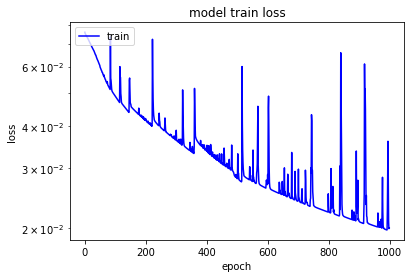

In [19]:
plot_graph(train_loss_arr, 'train')

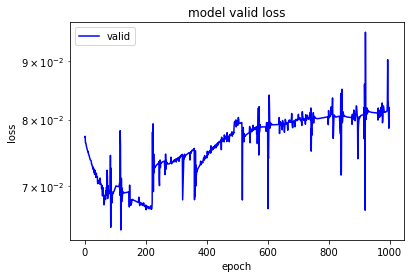

In [20]:
plot_graph(valid_loss_arr[0].reshape(-1,), 'valid')

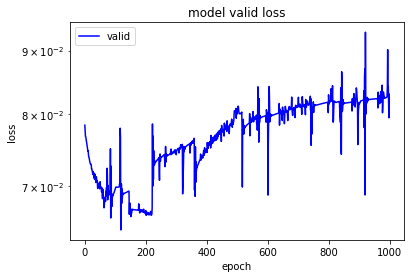

In [21]:
plot_graph(valid_loss_arr[1].reshape(-1,), 'valid')

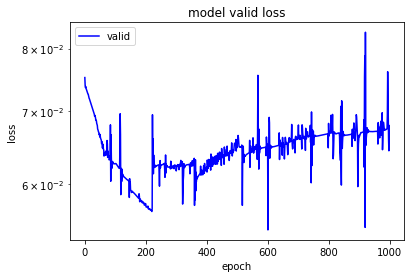

In [22]:
plot_graph(valid_loss_arr[2].reshape(-1,), 'valid')

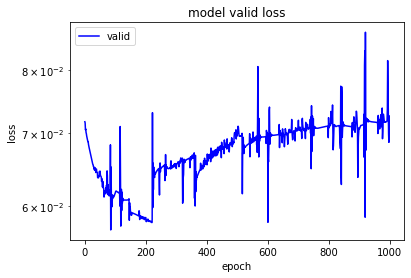

In [23]:
plot_graph(valid_loss_arr[3].reshape(-1,), 'valid')

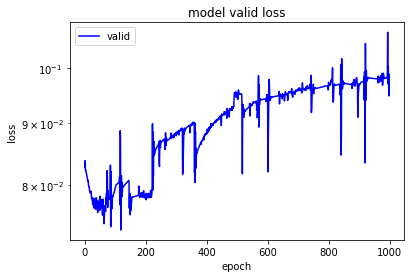

In [24]:
plot_graph(valid_loss_arr[4].reshape(-1,), 'valid')

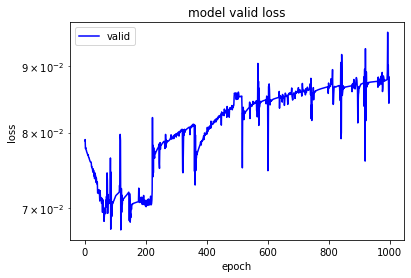

In [25]:
plot_graph(valid_loss_arr[5].reshape(-1,), 'valid')

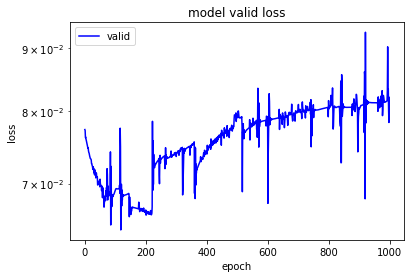

In [26]:
plot_graph(valid_loss_mean_arr, 'valid')

## Testing outputs of model

In [15]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)

In [16]:
num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, match)

Successfully loaded NPZ.


In [17]:
X_train = frames.reshape(1, len(frames) ,-1)/255

In [18]:
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [19]:
actions

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [20]:
action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
Y_train = np.array(action_one_hot)
Y_train = Y_train.reshape(1, len(Y_train), -1)

In [21]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [22]:
hx = torch.zeros(1, hidden_neurons)
cx = torch.zeros(1, hidden_neurons)
out_arr = []
for i in range(1000):
    step_input = X_train[0][i]
    step_input = step_input.reshape(1, -1)
    hx, cx = lstmcell(step_input, (hx, cx))
    out = linear(hx)
    out = output(out)
    out_arr.append(out)

In [23]:
Y_train = Y_train.reshape(-1, len(ACTIONS_LIST))

In [25]:
acertou = 0
errou = 0
for i in range(1000):
    if torch.argmax(Y_train[i]) == torch.argmax(out_arr[i]):
        acertou += 1
    else:
        errou += 1 

In [26]:
Y_train

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [27]:
acertou

839

In [28]:
errou

161

In [29]:
acertou/(acertou + errou)

0.839

## Play Gym Enduro

In [30]:
import gym
import time
from PIL import Image

ModuleNotFoundError: No module named 'gym'

In [31]:
if zigzag:
        
    ACTIONS = {
        "right": 2,
        "left": 3,
    }

else:

    ACTIONS = {
        "noop": 0,
        "accelerate": 1,
        "right": 2,
        "left": 3,
        "break": 4,
        "right_break": 5,
        "left_break": 6,
        "right_accelerate": 7,
        "left_accelerate": 8,
    }

In [32]:
y_min, y_max, x_min, x_max = 25, 195, 20, 140
shape_of_single_frame = (1, (y_max-y_min),(x_max-x_min))

In [33]:
sleep_time = 0.05

In [34]:
env = gym.make("Enduro-v0")
frame = env.reset()
reward, action, done, info = 0, 0, False, {'ale.lives': 0}

hx = torch.zeros(1, hidden_neurons)
cx = torch.zeros(1, hidden_neurons)

while(1000):
    
    time.sleep(sleep_time)
    env.render()
    
    frame = frame[y_min:y_max, x_min:x_max]

    frame = Image.fromarray(frame)
    frame = frame.convert("L")
    
    frame = np.asarray(frame)
    frame = frame.reshape(1, -1)
    frame = torch.tensor(frame)/255
    
    hx, cx = lstmcell(frame, (hx, cx))
    out = linear(hx)
    action = output(out)
    
    action = list(ACTIONS.values())[torch.argmax(action, axis=1)]
    print(action)
    frame, reward, done, info = env.step(action)

NameError: name 'gym' is not defined